<img src="header.png"></img>

<div align="center">
    <h1>Report on Participation in Kaggle Competition</h1>
    <h1>Part I: Introduction, Exploratory Data Analysis and Data Cleaning</h1>
</div>

<div align="center"><i>
In this Jupyter notebook I am getting acquainted with dataset provided in the framework of competition by its originator.<br/>
Also you can find a short description of the competition and its goals in the 'Intoduction' paragraph.<br/><br/>
Prepared by Artem Drofa.
</i></div>

## Introduction

<b>Kaggle Competition:</b><br/>
Elo Merchant Category Recommendation: Help understand customer loyalty [(link)](https://www.kaggle.com/c/elo-merchant-category-recommendation "Kaggle: Competition")

<b>Competition Originator:</b><br/>
[Elo](https://www.elo.com.br/ "Elo: Homepage") is one of the major domestic debit and credit card brands of Brazil. <u>(This means that provided data will be related to retail banking clients.)</u>


<b>Competition Description:</b><br/>
The goal of the competition is to predict a loyalty score for Elo's clients basing on data about their past transactions.<br/>
Elo says that their team has developed algorithm for prediction of relevant merchants to their clients. In the framework of the competition Elo provides participants with following data:

1. <b>Train & test data sheet</b> (202k & 124k entries, correspondingly), which conssist of unique card id, 1st purchase date, several anonymized features and target loyalty score for train sample.
2. <b>History transactions data sheet</b>, which provides data about 29mn transactions of Elo's customers. The data sheet also includes card_id and additional information about the transactions: normalized purchase amount, date, mechant id, merchant category id, city and state ids etc.
3. <b>New merchants transactions data sheet</b> is very similar to History transactions data sheet, but includes transactions performed after some reference date and <u>only</u> with merchants, which haven't been met in history transactions data sheet. <i>Supposingly, this reference date is a date of Elo's recommendation system activation.</i>
4. <b>Merchants data sheet</b> provides additional information about merchants: average sales and rvenues, several anonymized features, etc..

<a id='main_takeaways'></a>
## Main Takeaways
* Target values are distributed in \[-17.61; 17.96\] interval with mean at -0.03 and with ~1.1% outliers at -33.22. These outliers could sufficiently (negatively) influence competition (RMSE) score.
*  Distribution of existing features in train and test data sheets looks (visually) similarly. Due to this fact (most likely) there will be no need to rebalance train sample on the model training stage.
* There are about 8% of denied transactions in Historical Ttransactions data sheet, which should be taken into account on feature engenering stage.
* Since Elo has mentioned in competition description that they'd like to measure the effectiveness of developed reccomendation system, some features, which will show customer behavior dynamics, should be elaborated on feature engeneering stage.

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import os
import pickle
from IPython.core import display as ICD

import gc
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
PATH_TO_DATA = '.../data'

### Train and Test Data Sheets

In [3]:
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'))
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'))

Train and test data sheets preview:

In [4]:
ICD.display(train.head())
ICD.display(test.head())

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [5]:
#first_active_date to timestamp format
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
test['first_active_month'] = pd.to_datetime(test['first_active_month'])

In [6]:
#indexing
train.index = train['card_id']
test.index = test['card_id']

Checking if there are any NaN values.

In [7]:
print('There are NaNs in TRAIN data sheet:', train.isnull().values.any())
print('There are NaNs in TEST data sheet:', test.isnull().values.any())

There are NaNs in TRAIN data sheet: False
There are NaNs in TEST data sheet: True


In [8]:
test.isnull().values.sum(axis=0)

array([1, 0, 0, 0, 0])

Only one NaN in 'first_active_month' column, which (supposingly) could be replaced with 1st purchase date from historical transactions data sheet.

#### Features
Let's have a look on train & test data sheets features' distributions and compare them.

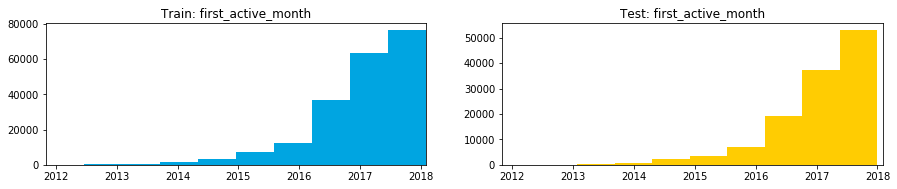

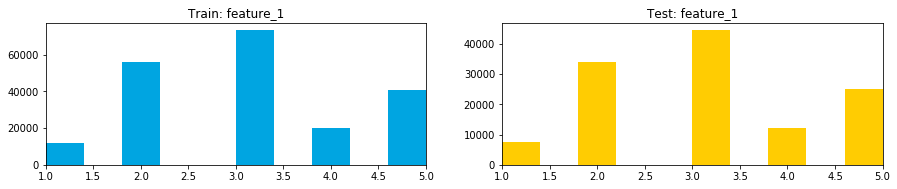

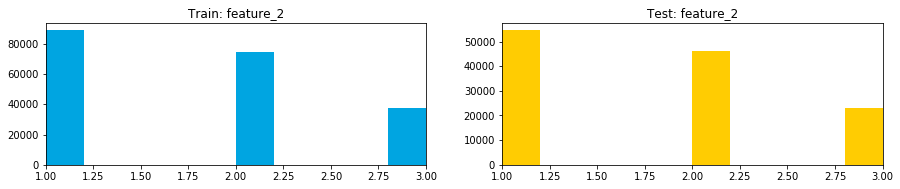

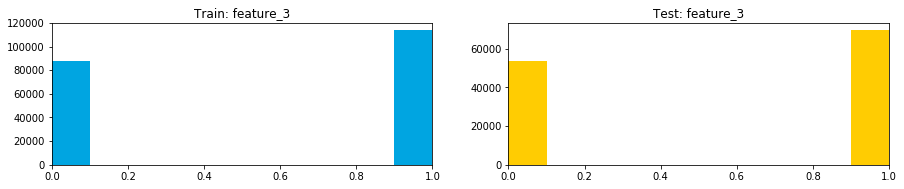

In [9]:
subplot = 1
for f in train.columns:
    if f not in ['card_id', 'target']:
        
        #General
        plt.figure(figsize=(15,12))
        xlim = (min( train[f].min(), test[f].min() ),
                max( train[f].max(), test[f].max() ))
        
        #Train
        plt.subplot(4, 2, subplot)
        plt.hist(train[f].dropna(), color='#00a5e1')
        plt.title('Train: '+f)
        plt.xlim(xlim)
        ylim = plt.ylim()
        subplot+=1
        
        #Test
        plt.subplot(4, 2, subplot)
        plt.hist(test[f].dropna(), color='#ffcc02')
        plt.title('Test: '+f)
        plt.xlim(xlim)
        #plt.ylim(ylim) #uncomment for y-axis assimilation 
        subplot+=1

pass

<b>Note</b>:<br/>
It could be said, that distributions of features given in train and test data sheets are quite similar, which (hopefully) won't require any train sample rebalance while model training.

#### Target
Let's have a look at target value distribution.

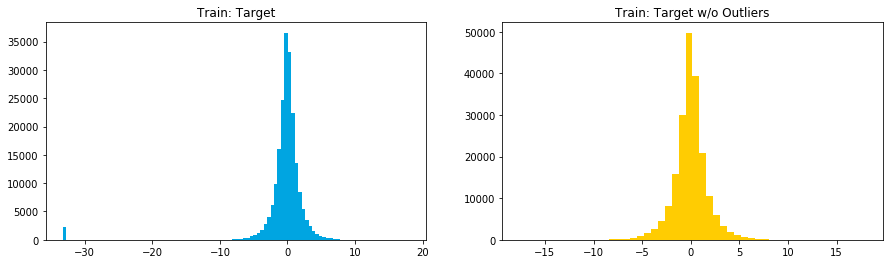

In [10]:
plt.figure(figsize=(15,4))

#Target
plt.subplot(121)
plt.hist(train['target'], bins=100, color='#00a5e1')
plt.title('Train: Target')

#Target w/o Outliers
plt.subplot(122)
import seaborn as sns
plt.hist(train[train['target']>train['target'].min()]['target'], bins=50, color='#ffcc02')
plt.title('Train: Target w/o Outliers')

pass

Histograms shows, that distribution of target value looks very similar to normal distribution, except several outliers.<br/>
Due to the fact that competition results evaluation will be based on <b>RMSE\*</b> the presence of these outliers among test targets could sufficiently affect final result.<br/>
<i>\*RMSE - root-mean-square error.</i>

In [11]:
print('Outliers\' value:', train['target'].min())
print('%-age of outliers:',
      train[train['target']==train['target'].min()].shape[0] / train.shape[0] * 100, '%')
print('Mean w/o outliers:', train[train['target']>train['target'].min()]['target'].mean())
print('Mean including outliers:', train['target'].mean())

Outliers' value: -33.21928095
%-age of outliers: 1.0930233709890698 %
Mean w/o outliers: -0.03087931272485137
Mean including outliers: -0.39363629907797143


### Historical Transactions and New Merchant Transactions Data Sheets

#### Memory Usage Optimization

Before analysis start, let's optimize memory usage and save optimized data sheets as pickle files. 

In [12]:
# Reduce Memory Function
# (https://www.kaggle.com/roydatascience/elo-stack-interactions-on-categorical-variables)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
#Historical transactions data sheet
hist_trans = pd.read_csv(os.path.join(PATH_TO_DATA, 'historical_transactions.csv'))
with open(os.path.join(PATH_TO_DATA, 'hist_trans_reduced_mem_usage.pkl'), 'wb') as pkl_f:
    pickle.dump(reduce_mem_usage(hist_trans), pkl_f)

del hist_trans
gc.collect()

#New merchant transactions data sheet
new_trans = pd.read_csv(os.path.join(PATH_TO_DATA, 'new_merchant_transactions.csv'))
with open(os.path.join(PATH_TO_DATA, 'new_trans_reduced_mem_usage.pkl'), 'wb') as pkl_f:
    pickle.dump(reduce_mem_usage(new_trans), pkl_f)
    
del new_trans
gc.collect()

pass

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


#### Analysis

In [14]:
#Loading optimized data sheets
with open(os.path.join(PATH_TO_DATA, 'hist_trans_reduced_mem_usage.pkl'), 'rb') as pkl_f:
    hist_trans = pickle.load(pkl_f)
with open(os.path.join(PATH_TO_DATA, 'new_trans_reduced_mem_usage.pkl'), 'rb') as pkl_f:
    new_trans = pickle.load(pkl_f)

In [15]:
ICD.display(hist_trans.head())
ICD.display(new_trans.head())

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


#### Missing Values 

Checking if there are any NaN values.

In [16]:
print('There are NaNs in hist_trans:', hist_trans.isnull().values.any())
print('There are NaNs in new_trans:', new_trans.isnull().values.any())

There are NaNs in hist_trans: True
There are NaNs in new_trans: True


Let's dive deeper and count total amount of NaNs in each column.

In [17]:
hist_trans_NaNs = pd.DataFrame(hist_trans.isnull().sum(axis=0), columns=['hist_trans NaNs'])
new_trans_NaNs = pd.DataFrame(new_trans.isnull().sum(axis=0), columns=['new_trans NaNs'])

hist_trans_NaNs.merge(new_trans_NaNs ,left_index=True, right_index=True)

,hist_trans NaNs,new_trans NaNs
authorized_flag,0,0
card_id,0,0
city_id,0,0
category_1,0,0
installments,0,0
category_3,178159,55922
merchant_category_id,0,0
merchant_id,138481,26216
month_lag,0,0
purchase_amount,0,0


1. NaNs are in the same columns of hist_trans and new_trans data sheets;
2. NaNs are in categorical features only.

Considering the fact that NaNs are in categorical features only, I do not see any reason (by current stage) to replace NaNs with any specific value (because, most likely categorical features will be one-hot encoded at feature engeneering stage).

#### Missing Values in Categorical Features (marked with -1)
Looking at data sheets preview it could be noticed, that there are some interconnection between city_id, category_1, category_2 and state_id features: -1 correlates with NaNs.<br/>For every object (in both samples: hist_trans, new_trans) NaNs in category_2 lead to -1 in state_id and vice versa.

In [18]:
print(hist_trans[hist_trans['category_2'].isnull()]['state_id'].unique())
print(hist_trans[hist_trans['state_id'] == -1]['category_2'].unique())

print(new_trans[new_trans['category_2'].isnull()]['state_id'].unique())
print(new_trans[new_trans['state_id'] == -1]['category_2'].unique())

[-1]
[nan]
[-1]
[nan]


Also there is information from Elo on competition forum that <b>-1 values are missing values</b>. Let's replace them with NaN for <u>categorical</u> features only.

In [19]:
hist_trans_minus_1 = pd.DataFrame((hist_trans == -1).sum(axis=0), columns=['hist_trans -1'])
new_trans_minus_1 = pd.DataFrame((new_trans == -1).sum(axis=0), columns=['new_trans -1'])

hist_trans_minus_1.merge(new_trans_minus_1 ,left_index=True, right_index=True)

,hist_trans -1,new_trans -1
authorized_flag,0,0
card_id,0,0
city_id,2478624,99349
category_1,0,0
installments,178159,55922
category_3,0,0
merchant_category_id,2252,20
merchant_id,0,0
month_lag,3627430,0
purchase_amount,0,0


In [20]:
for f in ['city_id', 'merchant_category_id', 'state_id', 'subsector_id']:
    hist_trans[f] = hist_trans[f].replace(-1, np.nan)
    new_trans[f] = new_trans[f].replace(-1, np.nan)

#### Authorized/ Denied Transactions

According to dictionary, provided by Elo (competition originator), authorized_flag feature means approved if 'Y' and denied if 'N'. Let's have a look at %-age of denied transactions in both samples.

In [21]:
print('%-age of denied transactions:')
print('- in hist_trans data sheet:',
      hist_trans[hist_trans['authorized_flag'] == 'N'].shape[0] / hist_trans.shape[0] * 100, '%')
print('- in new_trans data sheet:',
      new_trans[new_trans['authorized_flag'] == 'N'].shape[0] / new_trans.shape[0] * 100, '%')

%-age of denied transactions:
- in hist_trans data sheet: 8.64549941517969 %
- in new_trans data sheet: 0.0 %


Let's have a look, at a share of authorized transactions for each card_id.

In [22]:
hist_trans['authorized_flag'] = hist_trans['authorized_flag'].map({'Y':1, 'N':0})
new_trans['authorized_flag'] = new_trans['authorized_flag'].map({'Y':1, 'N':0})

In [23]:
auth_share = hist_trans.groupby(['card_id'])['authorized_flag'].mean()

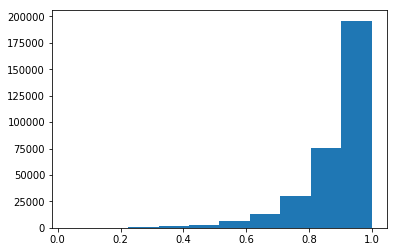

In [24]:
plt.hist(auth_share)
pass

For most of card_ids most of transactions were authorized, but there are some card_ids, which share of authorized transactions is extremely low.

Let's have a look at following relationships:
1. share of authorized transactions against total num of transaction;
2. share of authorized transactions against loyalty score (target).

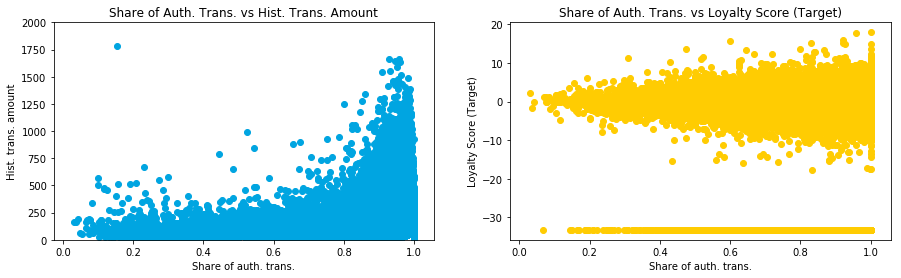

In [25]:
plt.figure(figsize=(15,4))

#%-age of authorized transactions against total num of transaction
plt.subplot(121)
plt.scatter(auth_share, hist_trans.groupby(['card_id'])['card_id'].count(), color='#00a5e1')
plt.title('Share of Auth. Trans. vs Hist. Trans. Amount')
plt.ylim(0, 2000)
plt.xlabel('Share of auth. trans.')
plt.ylabel('Hist. trans. amount')


#%-age of authorized transactions against loyalty score (target)
plt.subplot(122)
plt.scatter(auth_share.loc[train['target'].index], train['target'], color='#ffcc02')
plt.title('Share of Auth. Trans. vs Loyalty Score (Target)')
#plt.ylim(0, 2000)
plt.xlabel('Share of auth. trans.')
plt.ylabel('Loyalty Score (Target)')

pass

1. Card_ids with lower share of authorized transactions has lower total amount of transactions;
2. And, unfortunately there are no visually distinguishable dependence between share of authorized transactions and loyalty score (target).

#### Installments
Installments is one of few numerical features. Let's have a look at it in more details.

In [26]:
print('Unique installments values:')
print('- hist_trans:', hist_trans['installments'].unique())
print('- new_trans:', new_trans['installments'].unique())
print('Lists are equal:', set(hist_trans['installments'].unique()) == set(new_trans['installments'].unique()))

Unique installments values:
- hist_trans: [  0   1   5   3   4   2  -1  10   6  12   8   7   9  11 999]
- new_trans: [  1  -1   3   2  12   6   0   4  10   5   9   8   7  11 999]
Lists are equal: True


Actually, the number of unique values is quiet small, thus I believe that <b>this feature should be treated as a categorical</b>, not numerical.

999 and -1 values have no sense to be true, fortunately, there is information from Elo on competition forum that -1 and 999 values are missing values (i.e. NaNs). But, I think that there should be some reason to make them different.

After quik review of 'heads' of hist_ and new_ -trans data sheets, I've noticed, that installment feature has some interconnection with category_3 feature. Let's dig into more details.

In [27]:
print('hist_trans:')
print('\ninstallment = -1')
print('- installments=-1, category_3 unique values:',
      hist_trans[hist_trans['installments'] == -1]['category_3'].unique())
print('- category_3=NaN, installments unique values:',
      hist_trans[hist_trans['category_3'].isnull()]['installments'].unique())
print('\ninstallment = 999')
print('- installments=999, category_3 unique values:',
      hist_trans[hist_trans['installments'] == 999]['category_3'].unique())
print(' category_3=C, installments unique values:',
      hist_trans[hist_trans['category_3'] == 'C']['installments'].unique())

print('\n')
print('new_trans:')
print('\ninstallment = -1')
print('- installments=-1, category_3 unique values:',
      new_trans[new_trans['installments'] == -1]['category_3'].unique())
print('- category_3=NaN, installments unique values:',
      new_trans[new_trans['category_3'].isnull()]['installments'].unique())
print('\ninstallment = 999')
print('- installments=999, category_3 unique values:',
      new_trans[new_trans['installments'] == 999]['category_3'].unique())
print(' category_3=C, installments unique values:',
      new_trans[new_trans['category_3'] == 'C']['installments'].unique())

hist_trans:

installment = -1
- installments=-1, category_3 unique values: [nan]
- category_3=NaN, installments unique values: [-1]

installment = 999
- installments=999, category_3 unique values: ['C']
 category_3=C, installments unique values: [  5   3   4   2  10   6  12   8   7   9  11 999]


new_trans:

installment = -1
- installments=-1, category_3 unique values: [nan]
- category_3=NaN, installments unique values: [-1]

installment = 999
- installments=999, category_3 unique values: ['C']
 category_3=C, installments unique values: [  3   2  12   6   4  10   5   9   8   7  11 999]


Manipulations above show, that -1 in installments corresponds to NaNs in category_3 and vice versa, and 999 in installments corresponds to 'C' in category_3, but without inverse relation.<br/>
So <b>my hypothesis that -1 and 999 are different missing values could be <u>true</u></b>. For consistency in data representation I replace -1 with NaN and leave 999 as it is.

In [28]:
hist_trans['installments'] = hist_trans['installments'].replace(-1, np.nan)
new_trans['installments'] = new_trans['installments'].replace(-1, np.nan)

#### Purchase Amount

In [29]:
hpa = hist_trans['purchase_amount'].astype(float)
npa = new_trans['purchase_amount'].astype(float)

Most of purchase amount values are distributed around 0. Samples also include negative values:

In [30]:
print('hist_trans purchase amount min:', hpa.min())
print('new_trans purchase amount min:', npa.min())

hist_trans purchase amount min: -0.7469077706336975
new_trans purchase amount min: -0.7470703125


Hist_trans purchase amout includes 1 outlier  at  6010604 and contains 1006 values which are larger than max value in new_trans. Beside this distributions are very similar (visually). 

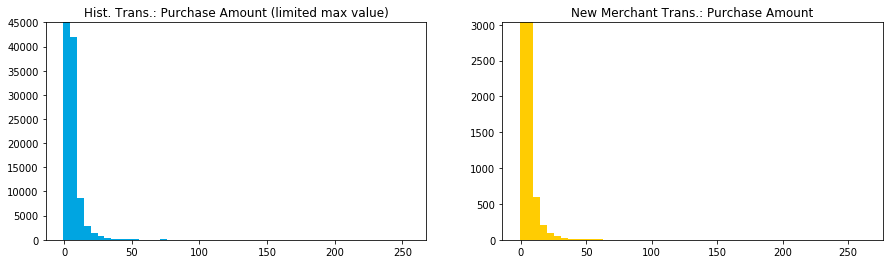

In [31]:
plt.figure(figsize=(15,4))

#Target
plt.subplot(121)
plt.hist(hpa[hpa <= npa.max()], bins=50, color='#00a5e1')
plt.title('Hist. Trans.: Purchase Amount (limited max value)')
plt.ylim(0, 45000)

#Target w/o Outliers
plt.subplot(122)
import seaborn as sns
plt.hist(npa, bins=50, color='#ffcc02')
plt.title('New Merchant Trans.: Purchase Amount')
plt.ylim(0, 45000 * npa.shape[0] / hpa.shape[0])

pass

I suppose, that working with negative purchase amounts in future will be uncomfortable. Any sums of purchase_amounts are under risk to result in negative or zero values, which is inappropriate and most likely will hurt a model of any type. Let's <b>transform the feature using Min-Max Scaling</b>.

In [32]:
scaler = MinMaxScaler(feature_range=(1 / 10**6, 1))
scaler.fit(np.concatenate((hpa.values, npa.values)).reshape(-1, 1))

hpa_adj = scaler.transform(hpa.values.reshape(-1, 1))
npa_adj = scaler.transform(npa.values.reshape(-1, 1))

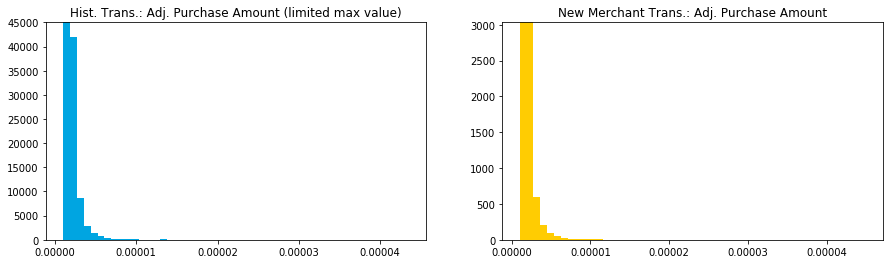

In [33]:
plt.figure(figsize=(15,4))

#hist_trans adj. purchase_amount
plt.subplot(121)
plt.hist(hpa_adj[hpa_adj <= npa_adj.max()], bins=50, color='#00a5e1')
plt.title('Hist. Trans.: Adj. Purchase Amount (limited max value)')
plt.ylim(0, 45000)

#new_trans adj. purchase_amount
plt.subplot(122)
import seaborn as sns
plt.hist(npa_adj, bins=50, color='#ffcc02')
plt.title('New Merchant Trans.: Adj. Purchase Amount')
plt.ylim(0, 45000 * npa_adj.shape[0] / hpa_adj.shape[0])

pass

In [34]:
#Replacing feature in data sheets
hist_trans['purchase_amount'] = hpa_adj
new_trans['purchase_amount'] = npa_adj

#### month_lag
(Supposingly) month__lag shows the difference between transaction date and reference date (date of Elo's recommendation system activation). Let's check, if this reference date is the same for every transaction and|or card_id.

In [35]:
#purchase_date to timestamp format
hist_trans['purchase_date'] = pd.to_datetime(hist_trans['purchase_date'])
new_trans['purchase_date'] = pd.to_datetime(new_trans['purchase_date'])

In [36]:
#hist_ and new_ -trans reference dates
hrd = hist_trans['purchase_date'] - pd.to_timedelta(hist_trans['month_lag'], unit='M')
nrd = new_trans['purchase_date'] - pd.to_timedelta(new_trans['month_lag'], unit='M')

In [37]:
#reference dates to 01-MM-YYYY format
hrd_1MY = pd.to_datetime(hrd.dt.year.astype(str) + '-' + hrd.dt.month.astype(str))
nrd_1MY = pd.to_datetime(nrd.dt.year.astype(str) + '-' + nrd.dt.month.astype(str))

In [38]:
#unique ref. dates %-age
hrd_counts = pd.DataFrame(hrd_1MY.value_counts(normalize=True), columns=['hist_ref_date_count_%']) * 100
nrd_counts = pd.DataFrame(nrd_1MY.value_counts(normalize=True), columns=['new_ref_date_count_%']) * 100
hnrd_counts = hrd_counts.merge(nrd_counts, how='outer', left_index=True, right_index=True)

hnrd_counts

,hist_ref_date_count_%,new_ref_date_count_%
2017-01-01,0.000058,0.007794
2017-02-01,0.021785,0.110085
2017-03-01,0.348787,1.002277
2017-04-01,0.534368,1.172727
2017-05-01,0.688467,1.306194
2017-06-01,0.915051,1.490094
2017-07-01,1.133227,1.604152
2017-08-01,1.420737,1.800430
2017-09-01,1.774686,2.134505
2017-10-01,2.073573,2.730930


Contrary to expectations reference dates are different for transactions. But, it is interesting, that ref_date_count_% increases chronologically, that could mean that Elo has been testing its reccomendation system on separated amount of clients before full start.

In [39]:
#adding reference dates to data sheets
hist_trans['ref_date_1MY'] = hrd_1MY
new_trans['ref_date_1MY'] = nrd_1MY

### Saving Transformed Data Sheets

Restoring NaN date in test data sheet from transactions data

In [40]:
#card_id with NaN
cin = test[test['first_active_month'].isnull()].index[0]
#min transaction date
mtd = min(hist_trans[hist_trans['card_id'] == cin]['purchase_date'].min(),
          new_trans[new_trans['card_id'] == cin]['purchase_date'].min())
#replacing NaN
test.loc[test['card_id'] == cin, 'first_active_month'] = mtd
#check
print('There are NaNs in TEST data sheet:', test.isnull().values.any())

There are NaNs in TEST data sheet: False


Saving pickle files.

In [41]:
data_sheets = [train, test, hist_trans, new_trans]
ds_title = [title+'.pkl' for title in ['train', 'test', 'hist_trans', 'new_trans']]

for ds, title in zip(data_sheets, ds_title):
    with open(os.path.join(PATH_TO_DATA, title), 'wb') as pkl_f:
        pickle.dump(ds, pkl_f)

## Conclusion
Please, consider ['Main Takeaways'](#main_takeaways) at the top of the page.